# Obtainment of D and K

Extract values of diffusion coefficient and trap stiffness in the media for BASEP experiments.
The final objective is to determine the optical tweezer stiffness and the potential landscape value in $k_BT$ units.

In [ ]:
#%reset

In [1]:
#Imports of libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mpc
import matplotlib as mpl
import pint
import scipy.optimize as spo
import scipy.spatial as spa
import pandas as pd
from tqdm import tqdm_notebook

ureg = pint.UnitRegistry()
import trackpy as tp

idx = pd.IndexSlice
%matplotlib inline

In [2]:
#Loading the tracking matrix from dat file 
filePath = "Coordinates_Test5_20190611.dat" 
trj = pd.read_csv(filePath ,sep = "\t", index_col=[0,1])
trj.x = trj.x*0.1805
trj.y = trj.y*0.1805
trj.head()

,,x,y,x0,y0,r,theta,time,theta_prime,theta_dot_prime
frame,particle,,,,,,,,,
0,0,62.592651,26.606984,0.119166,-0.263488,0.289182,-1.146062,0.000000,5.137124,NaN
1,0,62.627187,26.609574,0.310502,-0.249138,0.398097,-0.676186,0.006001,5.606999,78.305855
2,0,62.566806,26.667813,-0.024018,0.073516,0.077340,1.886571,0.013000,1.886571,366.109666
3,0,62.639070,26.710965,0.376334,0.312585,0.489221,0.693126,0.020000,0.693126,-170.504440
4,0,62.600564,26.709846,0.163004,0.306385,0.347048,1.081861,0.026001,1.081861,64.783504


(0, 0.06666666666666667)

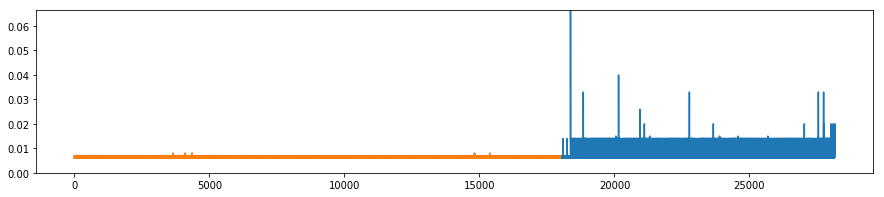

In [3]:
fig, ax = plt.subplots(1,1,figsize = (15,3))

useful_frames = np.arange(18000)
plt.plot(trj.time.diff().values)
plt.plot(trj.loc[idx[useful_frames,:],:].time.diff().values)

plt.ylim(0,10/150)

We look if we have lost frames during the video recording and select the range when the time between frames is almost constant.

## Trap stiffness

The first consideration we make to obtain the optical trap stiffness is that we have a purely harmonic potential in equilibrium state. Making this assumption, we therefore know the particle position in an arbitrary potential is:

$\rho (x) = C exp[\frac{-U(x)}{k_BT}]$

To obtain the trap stiffness we make an position histogram of a particle trapped by the optical tweezer ring.
By fitting a gaussian curve to the histogram, we approximate a parabola shaped curve.

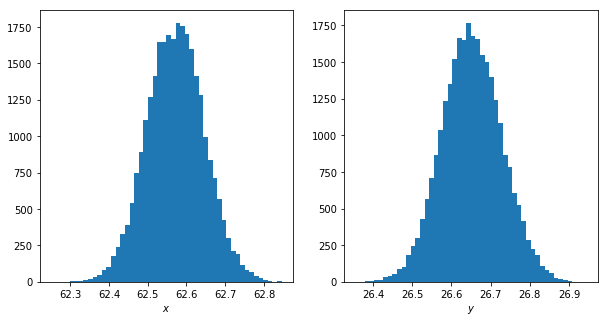

In [4]:
#Histogram of x positions of particle 1
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(trj.x, bins=50)
ax[1].hist(trj.y, bins=50)

#label the axes
ax[0].set_xlabel('$x$');
ax[1].set_xlabel('$y$');

mu =  0.002751080325470462 ; sigma =  0.4124239982936293 ; amplitude =  1502.6504674637488


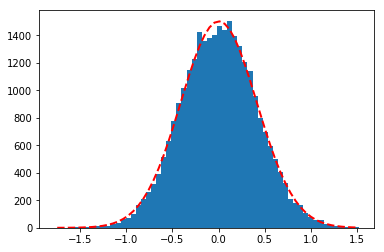

In [5]:
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from pylab import *

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

y, bins, patches = plt.hist(trj.x0, 60)

#Fitting gaussian in histogram
bins=(bins[1:]+bins[:-1])/2 #To have the same number of bins in the fitting

expected = (0,.5,1750) #gaussian epected params
params, cov = curve_fit(gauss, bins, y, expected)
sigma_func = sqrt(diag(cov))

gauss_fit = gauss(bins, *params)
plot(bins, gauss_fit, '--r', lw = 2) #color='red', lw=3, label='model')
print('mu = ', params[0], '; sigma = ', params[1], '; amplitude = ', params[2])

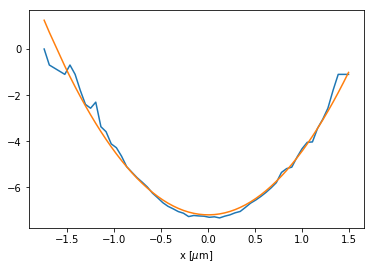

In [6]:
bins = bins[y>0]
y = y[y>0]
u_px = -np.log(y)


def parabola(x,a,b):
    return a*x**2+b

fit = curve_fit(parabola, bins, u_px)

plt.plot(bins, u_px)
plt.plot(bins,parabola(bins,*fit[0]))
plt.xlabel(r"x [$\mu{}$m]");

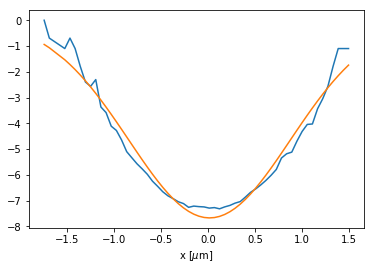

In [20]:
#exp_curve_fit = curve_fit(gauss, bins, u_px) 
params, cov = curve_fit(gauss, bins, u_px)

plt.plot(bins, u_px)
plt.plot(bins,gauss(bins,*params))
plt.xlabel(r"x [$\mu{}$m]");

In [22]:
print("mu = ", params[0], "; sigma = ", params[1], "; A = ", params[2])

mu =  0.014431943000939739 ; sigma =  -0.8595400358104557 ; A =  -7.670970612041237


In [24]:
a = fit[0][0]/ureg.um**2
a

2.7620531710674907 <Unit('1 / micrometer ** 2')>

In [25]:
kb = 1.38064852e-23 * ureg.J/ureg.K

In [27]:
kbT = (kb*300*ureg.K).to(ureg.pN*ureg.nm)
k = 2*a*kbT
k = k.to(ureg.pN/ureg.nm)
k

2.2880547736773826e-05 <Unit('piconewton / nanometer')>

Trap stiffness: $k = 2.288·10^{-5} pN/nm$

## Diffusion coefficient

In [10]:
def calculate_msd(series,lag_frame,col_name=None,framerate=1,particle_id = None):
    
    if col_name is None:
        col_name = series.columns.values
        
    def msd_point(lag):
        return np.nanmean((series[col_name].values[lag:]-series[col_name].values[:-lag])**2,axis=0)
    
    columns = ["msd_"+name for name in col_name]
    
    result =  pd.DataFrame(
        data=[msd_point(lag) for lag in lag_frame],
        index=lag_frame/framerate,columns=columns)
    
    result.index.name = "dt"

    if particle_id is not None:
        result["id"] = particle_id
        result["dt"] = result.index.values
        result = result.set_index(["dt","id"])
    
    return result

In [11]:
msd = calculate_msd(trj,np.arange(1,300),col_name = ["x","y"], framerate = 150).sum(axis=1)

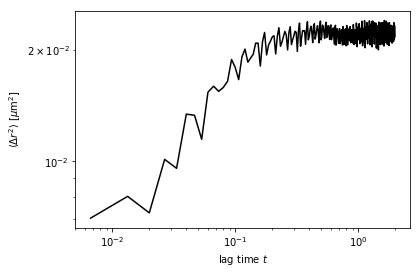

In [12]:
fig, ax = plt.subplots()
ax.loglog(msd, 'k-')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$');

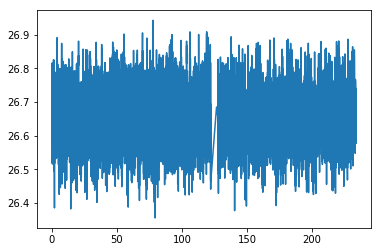

In [13]:
#plt.plot(trj.time,trj.x)
plt.plot(trj.time,trj.y)

lin fit slope =  0.5254745365869152 lin fit ind term =  -2.7731922667554034


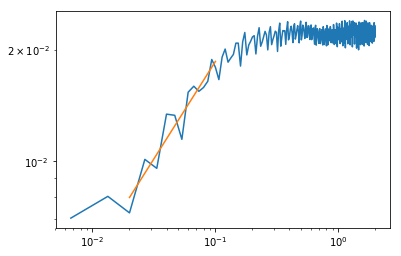

In [14]:
data_range = msd[(msd.index >= 0.02) & (msd.index <= 0.1)].index
#data_range = msd[msd.index <= 0.1].index.values
x = np.array(msd[data_range].index)
data = np.array(msd[data_range])


logX = np.log(x)
logData = np.log(data)

m, c = np.polyfit(logX, logData, 1) # fit log(y) = m*log(x) + c
pow_fit = np.exp(m*logX + c) # calculate the fitted values of y 


#lin_fit = np.polyfit(x, data, 1)

#rect = np.polyval(lin_fit, x)

plt.plot(msd)
plt.plot(x, pow_fit)

plt.xscale('log')
plt.yscale('log')
print("lin fit slope = ", m, "lin fit ind term = ", c)
#print("lin fit slope = ", lin_fit[0], "lin fit ind term = ", lin_fit[1])

The diffusion coefficient value is: $D = \frac{e^{b}}{2}$, where b is the independent number of the fit.

$D = 0.0313 \mu m^2/s$. 


Hence, the friction coefficient is: $\xi = k_BT/D = 31.92 k_BT=1.32·10^{-19} J·s/\mu m^2$, where $k_B = 1.3806·10^{-23} J/K$ and $T = 300 K$. 

# Fourier Space Determination of k

In [15]:
framerate = 150
dt = 1/framerate

In [16]:
def PSD(x,dt):
    F = np.fft.fft(x)
    N = len(x)
    PSD = (dt/N) * (F*F.conj())
    PSD = abs(PSD).astype("float64")
    f = np.linspace(0,framerate,N)
    return np.array_split(f,2)[0], np.array_split(PSD,2)[0]

In [17]:
def lorentzian(f,A,fc):
    return A/(fc**2+f**2)

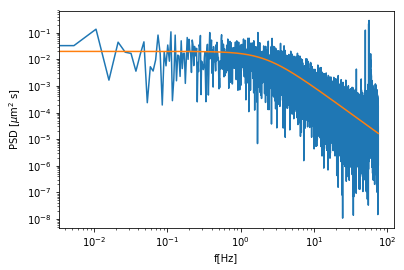

In [18]:
f, psd = PSD(trj.x0[1:],trj.time.diff()[1:])#dt)

fit = curve_fit(lorentzian, f, psd)

plt.loglog(f,psd)
plt.loglog(f,lorentzian(f,*fit[0]))
plt.xlabel(r"f[Hz]")
plt.ylabel(r"PSD [$\mu{}$m$^2$ s]");

In [19]:
A = fit[0][0] * ureg.um**2 / ureg.s
fc = fit[0][1] * ureg.Hz

In [20]:
gm = kbT/2/np.pi**2/A
gm.to(ureg.pN/(ureg.um/ureg.s))

0.002263304012497405 <Unit('piconewton * second / micrometer')>

In [21]:
gm_2 = 1/(2*np.pi**2*A)
gm_2 #in kbT units

0.5464349976867888 <Unit('second / micrometer ** 2')>

In [22]:
D = kbT/gm
D

1.8300438372968018 <Unit('micrometer ** 2 / second')>

In [23]:
(fc*2*np.pi*gm).to(ureg.pN/ureg.nm) #trap stifness

3.077070990990359e-05 <Unit('piconewton / nanometer')>

The diffusion coefficient value is: $D = 1.83 \mu m^2/s$. 


Hence, the friction coefficient is: $\xi = k_BT/D = 0.55 k_BT$

And the trap stiffness: $k = 3.077·10^{-5} pN/nm$

### How does this compare with expected value for a sphere in bulk? 

$\xi = 6\pi \eta R$;  $R = 4 \mu m$; $\eta = 8.90·10^{-4} Pa·s$ (for water)

In [24]:
R = 2*ureg.um
eta = 8.9e-4 * ureg.Pa * ureg.s
gm_ideal  = 6*np.pi*R*eta
gm_ideal.to(ureg.pN/(ureg.um/ureg.s))

0.033552209540338995 <Unit('piconewton * second / micrometer')>

In [25]:
gm_ideal.to(ureg.J/(ureg.um**2/ureg.s))

3.3552209540338983e-20 <Unit('joule * second / micrometer ** 2')>

The friction coefficient is: $\xi = 3.36·10^{-20} J·s/\mu m^2 = 8.1 k_BT$
 
Hence, the diffusion coefficient value is: $D = 0.123 \mu m^2/s$.

### How does this compare with a particle which is not trapped?

In [26]:
#Loading the tracking matrix from dat file 
filePath = "Tracking_DiffusionTest.dat" 
trj_d = pd.read_csv(filePath ,sep = "\t", index_col=[0])
trj_d.x = trj_d.x*0.1805
trj_d.y = trj_d.y*0.1805
trj_d.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,49.370765,63.735486,6811.277987,3.175158,0.007498,152.117349,27180.0,-0.072248,0,0
1,49.266848,63.804175,6851.430946,3.173788,0.021889,152.413408,27202.0,-0.076936,1,0
2,49.012128,63.241328,6766.053683,3.189732,0.006483,152.039451,27068.0,-0.062348,2,0
3,48.966668,63.276446,6797.868604,3.173609,0.027636,152.512449,27059.0,-0.054684,3,0
4,48.968935,63.274050,6838.793625,3.175963,0.032508,153.877382,27192.0,-0.054604,4,0


In [27]:
#Loading the timestamps of the video to have the time of each position
tmstmp_filePath = r"C:\Users\Eric\Desktop\BASEP_tests\DiffusionTest_NoLaser_2019_06_13_15_31_01.dat"
timestamp = pd.read_csv(tmstmp_filePath, sep="\r", header = None,names=["time"])

#Calculation of timestamps in nanoseconds
timestamp["datetime"] =  pd.to_datetime(timestamp.time+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
timestamp["ellapsed_time"] = (timestamp.datetime-timestamp.datetime[0])
timestamp.head()

,time,datetime,ellapsed_time
0,3.643277e+09,2019-06-13 15:31:01.361999989,00:00:00
1,3.643277e+09,2019-06-13 15:31:01.372000217,00:00:00.010000
2,3.643277e+09,2019-06-13 15:31:01.762000084,00:00:00.400000
3,3.643277e+09,2019-06-13 15:31:01.772000313,00:00:00.410000
4,3.643277e+09,2019-06-13 15:31:01.782000065,00:00:00.420000


In [28]:
#Timestamps to seconds and adding to t DataFrame 
trj_d["time"] = timestamp.ellapsed_time.dt.total_seconds()
trj_d = trj_d.filter(["x", "y", "frame", "particle", "time"])
trj_d.head()

,x,y,frame,particle,time
0,63.735486,49.370765,0,0,0.00
1,63.804175,49.266848,1,0,0.01
2,63.241328,49.012128,2,0,0.40
3,63.276446,48.966668,3,0,0.41
4,63.274050,48.968935,4,0,0.42


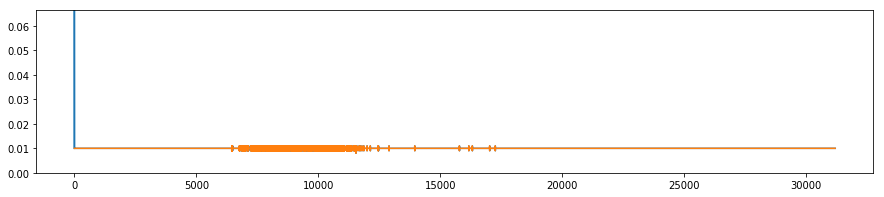

In [29]:
fig, ax = plt.subplots(1,1,figsize = (15,3))

#useful_frames = np.arange(18000)
plt.plot(trj_d.time.diff().values)
plt.plot(trj_d.loc[idx[5:],:].time.diff().values)

plt.ylim(0,10/150);

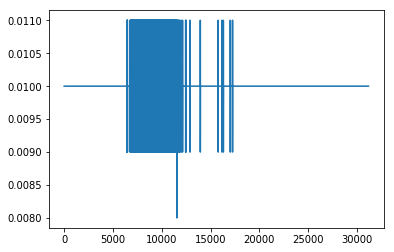

In [30]:
new_trj = trj_d.loc[idx[5:],:].reset_index()
plt.plot(new_trj.time.diff().values)

In [31]:
msd_tot = calculate_msd(new_trj,np.arange(1,30000,100), framerate = 100, col_name = ["x","y"]).sum(axis=1)
msd = calculate_msd(new_trj,np.arange(1,500,10), framerate = 100, col_name = ["x","y"]).sum(axis=1)

In [32]:
new_trj.head()

,index,x,y,frame,particle,time
0,5,63.317525,49.020733,5,0,0.43
1,6,63.333390,49.044515,6,0,0.44
2,7,63.385486,49.027705,7,0,0.45
3,8,63.417723,49.103994,8,0,0.46
4,9,63.506490,49.076448,9,0,0.47


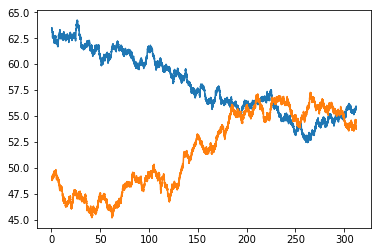

In [33]:
plt.plot(new_trj.time,new_trj.x)
plt.plot(new_trj.time,new_trj.y)

## Remove drift

In [34]:
v = new_trj.diff()
v.x = v.x/v.time
v.y = v.y/v.time

v.mean()

index       1.000000
x          -0.023718
y           0.015368
frame       1.000000
particle    0.000000
time        0.010000
dtype: float64

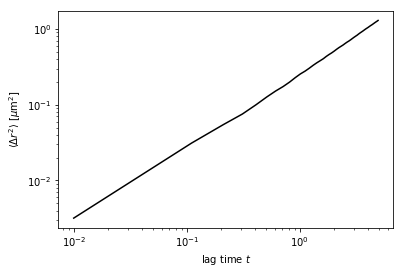

In [35]:
fig, ax = plt.subplots()
#ax.plot(msd, 'k-')
ax.loglog(msd, 'k-')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]', xlabel='lag time $t$');

linear fit slope =  0.9881082225617236 linear fit ind term =  -1.3509660445425098


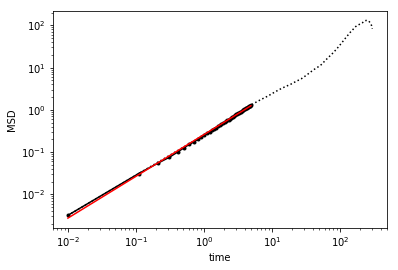

In [36]:
#data_range = msd[(msd.index >= 0.0) & (msd.index <= 0.1)].index
#data_range = msd[msd.index <= 0.1].index.values
x = np.array(msd.index)
data = np.array(msd)


logX = np.log(x)
logData = np.log(data)

m, c = np.polyfit(logX, logData, 1) # fit log(y) = m*log(x) + c
pow_fit = np.exp(m*logX + c) # calculate the fitted values of y 

#lin_fit = np.polyfit(x, data, 1)

#rect = np.polyval(lin_fit, x)

plt.plot(msd_tot,":",color="k")
plt.plot(msd,".-",color="k")
plt.plot(x, pow_fit, "r")

plt.xscale('log')
plt.yscale('log')
plt.xlabel("time")
plt.ylabel("MSD")
print("linear fit slope = ", m, "linear fit ind term = ", c)
#print("lin fit slope = ", lin_fit[0], "lin fit ind term = ", lin_fit[1])

The diffusion coefficient value is: $D = 0.1295 \mu m^2/s$. 


Hence, the friction coefficient is: $\xi = k_BT/D = 7.72 k_BT=3.197·10^{-20} J·s/\mu m^2$

, where $k_B = 1.3806·10^{-23} J/K$ and $T = 300 K$. 